In [1]:
# Make imports
import opcsim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# turn off warnings temporarily
import warnings
warnings.simplefilter('ignore')

# Let's set some default seaborn settings
sns.set(context='notebook', style='ticks', palette='deep', font_scale=1.75)

# The OPC Model

The `opcsim.OPC` class provides an easy-to-use interface for modeling low-cost optical particle counters. This simple model is based on just a few variables. Any OPC can be described by the following:

  * An OPC has $n_bins$ histogram bins
  * An OPC has a lower cutoff at some diameter ($dmin$) and upper cutoff at some diameter ($dmax$)
  * An OPC has a counting efficiency that can either be constant or vary with particle diameter
  * 
  
To define a model OPC using the `opcsim.OPC` class, we simply initiate as follows:

In [2]:
opc = opcsim.OPC()

When initiated with no arguments, the default arguments are used. This sets $dmin=0.5\;\mu m$, $dmax=2.5\;\mu m$, and $n_bins=1$. We can view the number of bins using the `OPC.n_bins` attribute.

In [4]:
opc.n_bins

1

We can also view the bin boundaries and midpoint diameters using the `OPC.bins` attribute. Here, we receieve a 3xn array where the first entry is the left bin boundary, the middle is the midpoint diameter, and the last entry is the right bin boundary.

In [5]:
opc.bins

array([[ 0.5       ,  1.11803399,  2.5       ]])

## Building an OPC

We can build more complex models by increasing the number of bins in a couple of ways: (1) we can change the minimum or maximum cutoffs, or the total number of bins:

In [6]:
opc_10bins = opcsim.OPC(n_bins=10, dmin=0.3, dmax=17)

opc_10bins.bins

array([[  0.3       ,   0.36710275,   0.44921476],
       [  0.44921476,   0.54969325,   0.67264635],
       [  0.67264635,   0.82310108,   1.0072089 ],
       [  1.0072089 ,   1.23249719,   1.50817703],
       [  1.50817703,   1.84551978,   2.25831796],
       [  2.25831796,   2.76344911,   3.38156589],
       [  3.38156589,   4.13794047,   5.06349775],
       [  5.06349775,   6.19607983,   7.58199316],
       [  7.58199316,   9.2779018 ,  11.35314422],
       [ 11.35314422,  13.89256822,  17.        ]])

If we are trying to build mimic an OPC that has pre-defined bins, we can also do that with the help of some utility methods. The bins argument in the OPC class requires a 3xn array as seen above. Often, you may only have the bin boundary information and not the midpoints. Typically, we use the logarithmic mean rather than the arithmetic mean, though we have made both available through the `opcsim.midpoints` utility function.

For example, let's calculate the bins for an OPC like the Dylos DC1100 Pro. This OPC has two bins (0.5-2.5, 2.5-10). How do we build the bins?

In [8]:
bins = np.array([[0.5, 2.5], [2.5, 10]])

bins = opcsim.midpoints(bins)

bins

array([[  0.5       ,   1.11803399,   2.5       ],
       [  2.5       ,   5.        ,  10.        ]])

If we build bins from 'scratch' as above, when we initiate the OPC model, we need to only include the bins as an argument:

In [11]:
dylos = opcsim.OPC(bins=bins)

The last argument of interest to the OPC model is the counting efficiency (`ce`). The counting efficiency argument must be a callable function that accepts the particle diameter and returns a float. By default, counting efficiency is set to return 1 at all diameters. You can provide any function you want. However, as of now, the counting efficiency is only evaluated at bin midpoints.

For example, if you wanted to change the counting efficiency to be a linear function, you could set it as something like:

In [16]:
# define the counting efficiency function
ce = lambda x: 1.25*x + 0.05

opc_ce = opcsim.OPC(n_bins=10, ce=ce)

That more or less covers how we build an OPC. Next, how do we determine what an OPC "sees" given an aerosol distribution?

## Evaluating an OPC

To determine what the OPC "sees", we evaluate the PDF of the aerosol distribution present at the midpoint diameter of each bin and multiply by the counting efficiency at that diameter. We can use the `OPC.evaluate` method to calculate these values for any combination of `weight` and `base`. The defaults are `weight='number'` and `base='log10'`. This returns a value that is the $dN/dlogD_p$ value in units of $cm^{-3}$.

In [22]:
opc = opcsim.OPC(n_bins=5, dmin=0.3, dmax=2.5)
urban = opcsim.load_distribution("Urban")

opc.evaluate(distribution=urban)

array([  3.04815785e+02,   3.57911500e+01,   1.87041608e+00,
         4.33304183e-02,   4.44549802e-04])

## Plotting OPC Response to the Urban Distribution

Now that we know how to evaluate the response of an OPC to the urban distribution, how can we easily visualize it? Well, we have the handy `opcsim.plots.histplot` to do that! All we need is the data to plot (evaluated PDF) and the OPC bins.

Let's go ahead and plot the response of a 10-bin OPC to the Urban Aerosol Distribution:

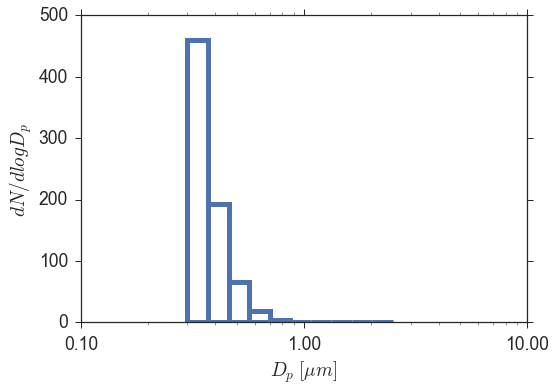

In [26]:
# Set the 10-bin OPC
opc = opcsim.OPC(n_bins=10, dmin=0.3, dmax=2.5)

# Build a distribution
urban = opcsim.load_distribution("Urban")

# Plot
ax = opcsim.plots.histplot(opc.evaluate(urban), opc.bins)

ax.set_ylabel("$dN/dlogD_p$")

plt.show()

Why don't we go ahead and overlay the distribution itself:

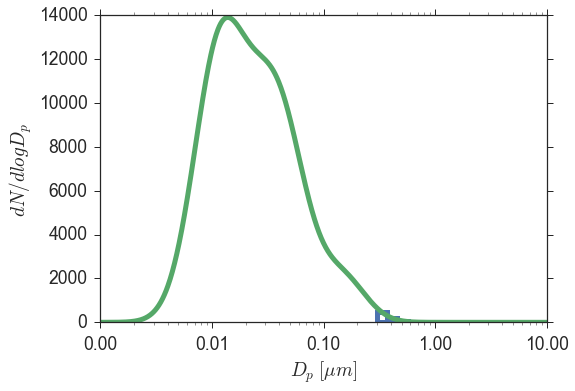

In [27]:
# Plot
ax = opcsim.plots.histplot(opc.evaluate(urban), opc.bins)

# Add the distribution to the plot
ax = opcsim.plots.pdfplot(urban, ax=ax)

ax.set_ylabel("$dN/dlogD_p$")

plt.show()

The above plots are in number-space. The primary use of these low-cost sensors is to estimate mass, so why don't we go ahead and plot this in volume space?

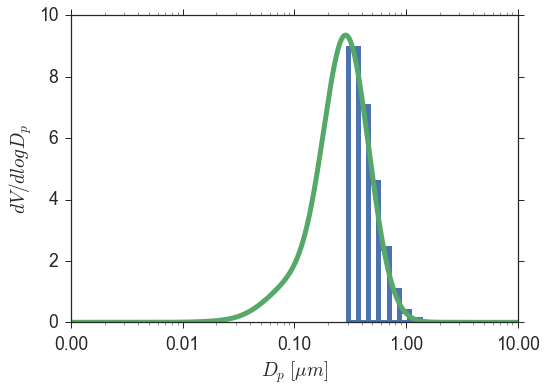

In [29]:
# Plot
ax = opcsim.plots.histplot(opc.evaluate(urban, weight='volume'), opc.bins)

# Add the distribution to the plot
ax = opcsim.plots.pdfplot(urban, weight='volume', ax=ax)

ax.set_ylabel("$dV/dlogD_p$")

plt.show()

# Scoring an OPC Model